# **Network Dynamics and Learning HW3**

##**Team Members**:

**Parovic, Ana (344174)**;

**Aljosevic, Ismail (337769)**;

## **Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
from itertools import product
from sklearn.metrics import root_mean_squared_error
import itertools
from matplotlib.patches import Patch
import math

# **Exercise 1 : Influenza H1N1 2009 Pandemic in Sweden**

## **1.1 Epidemic on a known graph**

#### **Generating symmetric k-regular graph**


In [ ]:
def symmetric_k_regular_graph(n, k):

  G = nx.Graph()
  G.add_nodes_from(range(1, n + 1))

  half = k // 2 #For each node, we connect it to its 2 closest nodes at one time, remaining 2 will be added when these nodes are being proccessed.
  for i in range(1, n + 1):
      for d in range(1, half + 1):
          j = ((i - 1 + d) % n) + 1   # i + d modulo n (back to 1..n)
          G.add_edge(i, j) # no need to add (i - d) separately because when that neighbor is processed

  return G


### **Simulating SIR epidemic model**


In this case we consider a discrete-time, simplified SIR epidemic model. Time evolves in discrete steps
$t = 0,1,2,\dots$, and each node $i$ can be in one of three states:
$$
X_i(t) \in \{S, I, R\},
$$
where $S$ denotes susceptible, $I$ infected, and $R$ recovered.

Let $\beta \in [0,1]$ be the probability that an infection is transmitted from an infected node to a susceptible neighbor during a single time step.  
If a susceptible node $i$ has $m$ infected neighbors at time $t$, then the probability that node $i$ is not infected by any of them during one time step is
$$
(1 - \beta)^m.
$$
Consequently, the probability that node $i$ becomes infected during that time step is
$$
1 - (1 - \beta)^m.
$$

Let $\rho \in [0,1]$ denote the probability that an infected node recovers during one time step.  
The epidemic dynamics are governed by the following transition probabilities:
$$
P\bigl(X_i(t+1) = I \,\big|\, X_i(t) = S,\; \sum_{j \in V} W_{ij}\,\delta_{X_j(t)}^{I} = m \bigr)
= 1 - (1 - \beta)^m,
$$
$$
P\bigl(X_i(t+1) = R \,\big|\, X_i(t) = I \bigr) = \rho.
$$

Here, $W_{ij}$ denotes the adjacency matrix of the network, and $\delta_{X_j(t)}^{I}$ is an indicator function equal to $1$ if node $j$ is infected at time $t$ and $0$ otherwise. Thus,
$$
\sum_{j \in V} W_{ij}\,\delta_{X_j(t)}^{I}
$$
represents the number of infected neighbors of node $i$ at time $t$.

<!-- **REMARK:** Due to the high complexity of the underlying network, it is computationally infeasible to apply the general simulation framework for continuous-time Markov chains. In particular, a full analysis based on the explicit construction of the transition matrix $\Lambda$ is not possible. Number of possible states is equal to: $3^{500}$ -->

In [ ]:
def simulate_SIR_dynamic(G, beta, rho, T = 15, N = 100, init_infected = 10):

  W = nx.to_scipy_sparse_array(G, format="csr")  # sparse adjacency (CSR)
  num_of_agents = len(G)
  S, I, R = 0, 1, 2

  #for each run (N), and each week in the run (T)
  S_counts = np.zeros((N, T + 1))
  I_counts = np.zeros((N, T + 1))
  R_counts = np.zeros((N, T + 1))
  new_infections = np.zeros((N, T))

  rng = np.random.default_rng(42)

  for run in range(N):
      x = np.zeros(num_of_agents)
      infected_idx = rng.choice(num_of_agents, size=init_infected, replace=False)
      x[infected_idx] = I

      # record week 0 totals
      S_counts[run, 0] = np.sum(x == S)
      I_counts[run, 0] = np.sum(x == I)
      R_counts[run, 0] = np.sum(x == R)

      for t in range(T):

          inffected = (x == I) # who is infeccted
          m = W @ inffected  # for each node we get number of inffected neihbours

          p_inf = 1 - (1 - beta)**m

          #Based on probabilities, choose specific numbe
          sus_mask = (x == S) # it is only possible to go from S to I
          u = rng.random(num_of_agents)
          will_infect = sus_mask & (u < p_inf) #  & acts like element wise AND operator (Chat GPT trick)

          inf_mask = (x == I)
          u2 = rng.random(num_of_agents)
          will_recover = inf_mask & (u2 < rho)

          new_infections[run, t] = np.sum(will_infect)

          x_next = x.copy()
          x_next[will_infect] = I
          x_next[will_recover] = R

          x = x_next
          # record totals at week t+1
          S_counts[run, t + 1] = np.sum(x == S)
          I_counts[run, t + 1] = np.sum(x == I)
          R_counts[run, t + 1] = np.sum(x == R)

  # Average over runs
  avg_new_inf = new_infections.mean(axis=0)
  avg_S = S_counts.mean(axis=0)
  avg_I = I_counts.mean(axis=0)
  avg_R = R_counts.mean(axis=0)

  return avg_new_inf, avg_S, avg_I, avg_R

In [ ]:
n = 500
k = 4
G = symmetric_k_regular_graph(n, k)
beta = 0.3
rho = 0.7

avg_new_inf, avg_S, avg_I, avg_R = simulate_SIR_dynamic(G, beta, rho)

### **Average number of newly infected per week**

In [ ]:
def plot_avg_new_infected(avg_new_inf_list,labels=None,T=15,N=100, name=None):
    weeks = np.arange(1, T + 1)

    plt.figure()

    for i, avg_new_inf in enumerate(avg_new_inf_list):
        if labels:
            plt.plot(weeks, avg_new_inf, marker='o', label=labels[i])
        else:
            plt.plot(weeks, avg_new_inf, marker='o')

    plt.xticks(weeks)
    plt.xlabel("Week")
    plt.ylabel("Avg newly infected")
    plt.title(f"Average newly infected per week (N={N})")
    plt.grid(True)

    if labels:
        plt.legend()

    plt.savefig(f"{name}.pdf")

    plt.show()


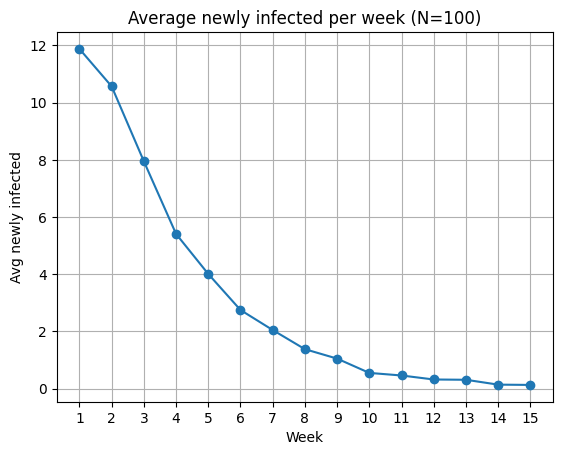

In [ ]:
plot_avg_new_infected([avg_new_inf])

### **Observation:**

The average number of newly infected individuals per week decreases monotonically over time, indicating that the epidemic peaks at the beginning of the simulation and gradually dies out.

### **Analysing the influence of node degree (additional part)**

We compare results obtained for k, by doubling it each time. [4, 8, 16]

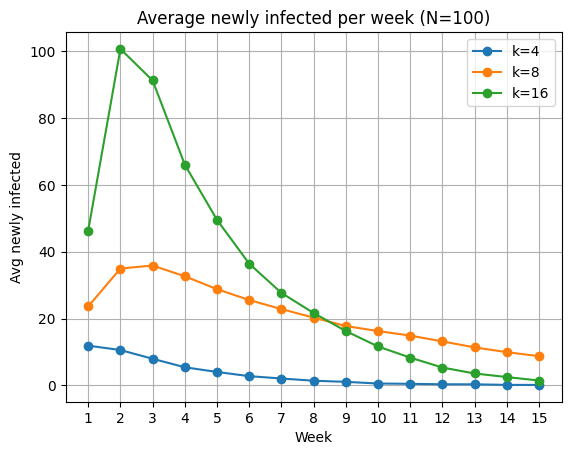

In [ ]:
ks = [4, 8, 16]

avg_new_infs = []

avg_total_sus = []
avg_total_in = []
avg_total_recs = []
for k in ks:
  G = symmetric_k_regular_graph(n, k)
  temp, S, I, R = simulate_SIR_dynamic(G, beta, rho)
  avg_new_infs.append(temp)

  avg_total_sus.append(S)
  avg_total_in.append(I)
  avg_total_recs.append(R)

plot_avg_new_infected(avg_new_infs, ["k=4", "k=8", "k=16"])

### Observations:

For k=4, the epidemic rapidly dies out. When the degree is increased to  k=8, the epidemic no longer goes extinct but persists over time with a moderate and sustained number of new infections. In contrast, for k=16 the epidemic spreads very rapidly, producing a strong early peak and then quickly infecting the susceptible population, which leads to a rapid decline of new infections.

### **Average total number of suscepted, inffectes and recovered**

In [ ]:
def plot_avg_SIR(sir_list, T=15, N=100):

    weeks = np.arange(0, T + 1)
    num_plots = len(sir_list)

    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(8 * num_plots, 6),
        sharey=True
    )

    if num_plots == 1:
        axes = [axes]

    for ax, (avg_S, avg_I, avg_R, label) in zip(axes, sir_list):
        ax.plot(weeks, avg_S, label="Susceptible (S)", linewidth=2.5)
        ax.plot(weeks, avg_I, label="Infected (I)", linewidth=2.5)
        ax.plot(weeks, avg_R, label="Recovered (R)", linewidth=2.5)

        ax.set_title(label, fontsize=16)
        ax.set_xlabel("Week", fontsize=16)
        ax.tick_params(axis="both", labelsize=16)
        ax.grid(True)
        ax.legend(fontsize=12)

    axes[0].set_ylabel("Avg number of individuals", fontsize=16)

    # fig.suptitle(
    #     f"Average SIR dynamics (N={N})",
    #     fontsize=22
    # )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("multiple_sir.pdf", bbox_inches="tight")
    plt.show()


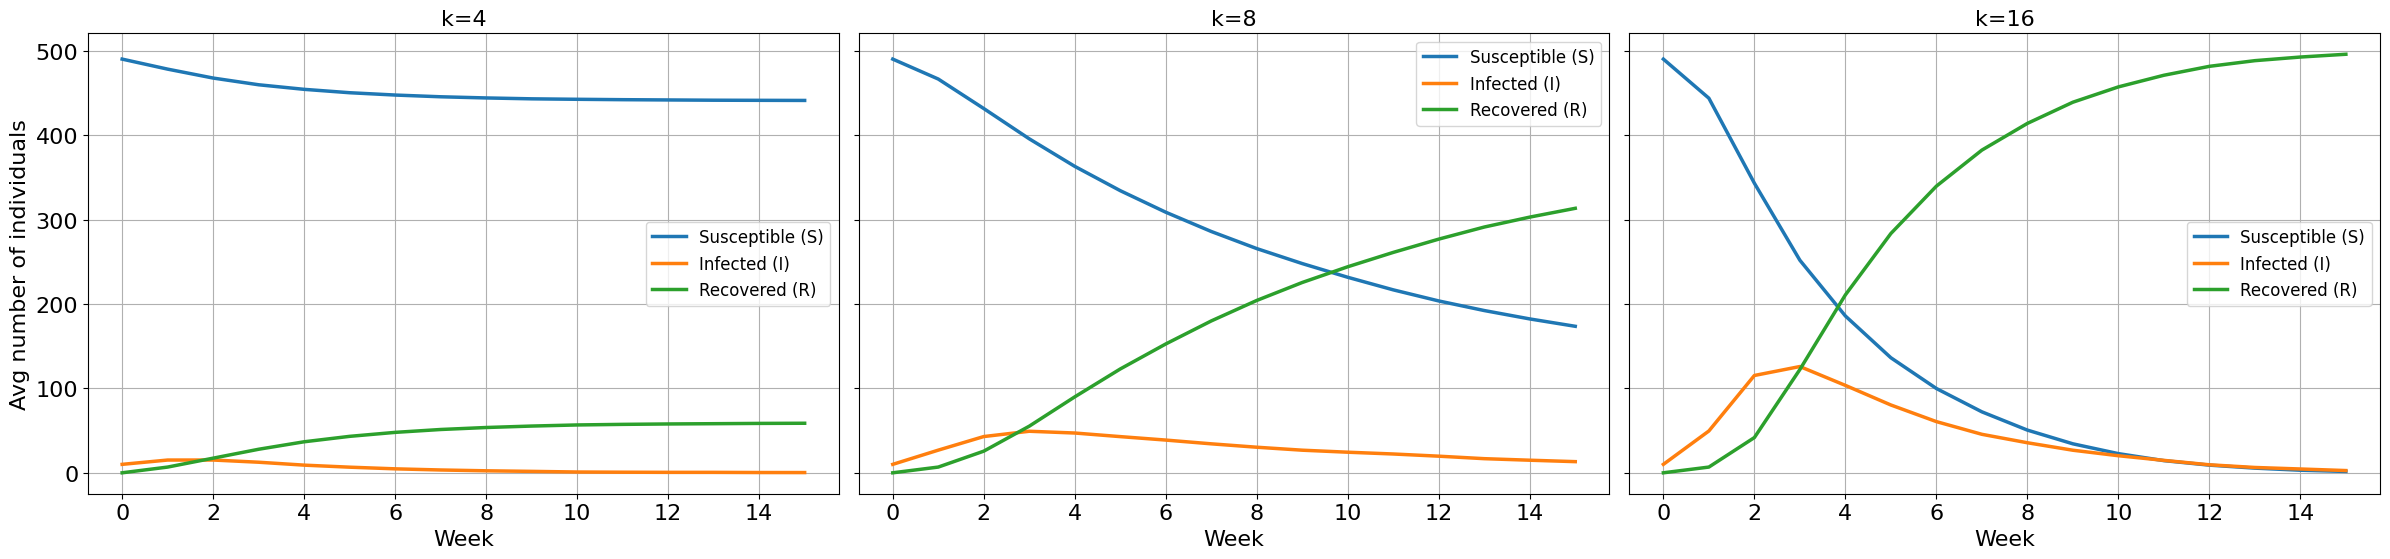

In [ ]:
plot_avg_SIR([
    (avg_total_sus[0], avg_total_in[0], avg_total_recs[0], "k=4"),
    (avg_total_sus[1], avg_total_in[1], avg_total_recs[1], "k=8"),
    (avg_total_sus[2], avg_total_in[2], avg_total_recs[2], "k=16"),
])

### Observation:
Infected(t)​=Infected(t−1)​+New(t)​−Recovered(t)

The results show that the number of infected individuals closely follows the number of newly infected individuals in each week. Once the number of newly infected individuals starts to decrease, the total number of infected individuals also decreases almost simultaneously. This behavior indicates that there is no significant accumulation of infected individuals over time. Most individuals who become infected in a given week recover within the same or the following week, implying that the disease duration is approximately one week. Due to this short infectious period, the epidemic dynamics are primarily driven by the number of new infections occurring in each week rather than by long-term persistence of infected individuals.


## **1.2 Generate a random graph**

#### **Preferential attachment model**

The idea of this model is following:

- at time t = 0 we start with an initial undiricted graph $G_0$
- at each time, we create a new graph $G_t$ by adding a new node to the graph from the previous iteration $G_{t-1}$ and connect
it to some of the existing nodes chosen according to some stochastic rule..


Preferential attachment rule means that at every time-step $t ≥ 2$, every new node added at time t will have a degree $w_t(t) = c = k/2.$

Hence, it should add c undirected links to the existing graph Gt−1. It decides
which of the nodes in Vt−1 it should connect to based on some probability that is **proportional to the current degree of the node** it is connecting to. In other words, if we denote the new node $n_t$, the probability that there will be a link between node $n_t$ and node $i ∈ V_{t−1}$ is:

$$
\mathbb{P}\!\left(
W_{n_t,i}(t) = W_{i,n_t}(t) = 1 \;\middle|\; \mathcal{G}_{t-1} = (\mathcal{V}_{t-1}, \mathcal{E}_{t-1})
\right)
=
\frac{w_i(t-1)}{\sum_{j \in \mathcal{V}_{t-1}} w_j(t-1)},
\qquad i \in \mathcal{V}_{t-1}.
$$

If k happens to be an odd number, then c = k/2 will not be an
integer. However, it is still possible to achieve an average degree of k when you add a large number
of nodes. This can be done by alternating between adding ⌊k/2⌋ and ⌈k/2⌉ links when adding a
new node to the graph.

In [ ]:
def generate_preferential_attachement(n, k):

  #Generate initial graph
  k_0 = k+1
  G = nx.complete_graph(k_0)
  c = k//2
  rng = np.random.default_rng(42)

  for i in range(k_0, n):

    #Compute degrees for each node in the current graph
    deg = np.array([d for _, d in G.degree()])
    nodes = np.array(list(G.nodes()))
    probs = deg / deg.sum()   # already sums to 1

    # number of edges to add for this new node
    m = c + (k % 2) * ((i - k_0) % 2) #altering

    G.add_node(i)
    chosen = rng.choice(nodes, size=m, replace=False, p=probs)
    G.add_edges_from((i, v) for v in chosen)


  return G

In [ ]:
G = generate_preferential_attachement(1000, 4)

degrees = np.array([d for _, d in G.degree()])
mean = degrees.mean()

print(f"Number of nodes: {len(G)}")
print(f"Average degree: {mean}")

Number of nodes: 1000
Average degree: 4.0


## **1.3 Simulate a pandemic without vaccination**





In [ ]:
n = 500
k = 6
G = generate_preferential_attachement(n, k)
beta = 0.3
rho = 0.7

avg_new_inf, avg_S, avg_I, avg_R = simulate_SIR_dynamic(G, beta, rho)

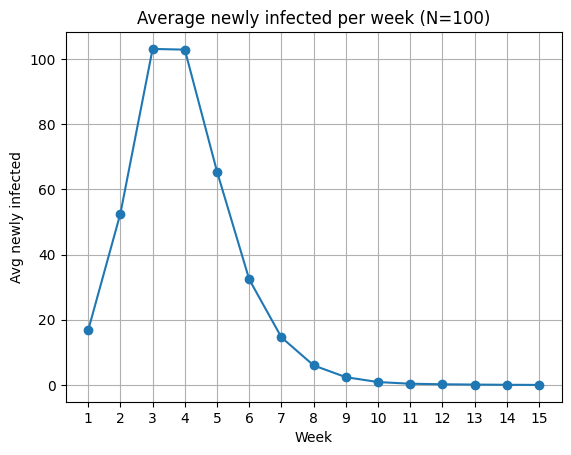

In [ ]:
plot_avg_new_infected([avg_new_inf])

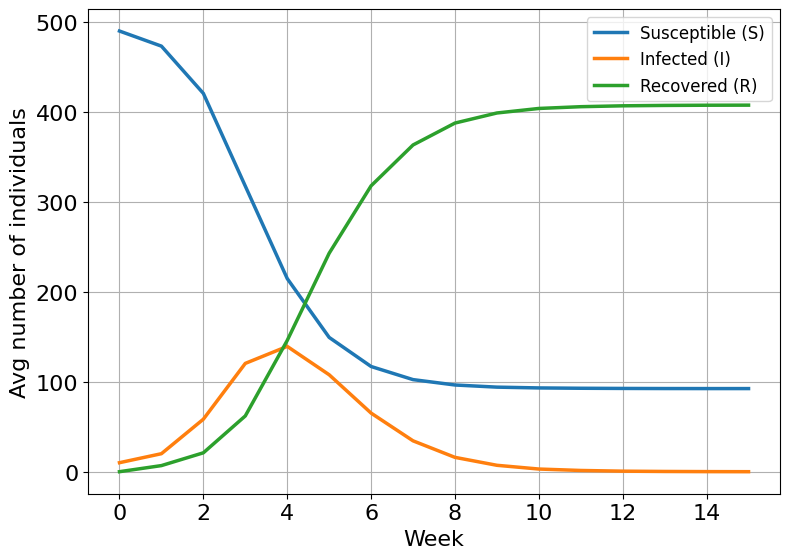

In [ ]:
plot_avg_SIR([(avg_S, avg_I, avg_R, "")])

### **Observations**
The results obtained on the preferential attachment network show a rapid and intense spreading process. The number of newly infected individuals exhibits a strong early peak, indicating fast transmission driven by highly connected nodes. This behavior is also reflected in the SIR dynamics, where the susceptible population decreases sharply while the recovered population increases rapidly. After the early peak, the number of infected and newly infected individuals quickly declines, suggesting that the epidemic dies out once the highly connected nodes are exhausted.



## **1.4 Simulate a pandemic with vaccination**

In [ ]:
def simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, init_infected=10, T=15, N=100):

    W = nx.to_scipy_sparse_array(G, format="csr")
    num_of_agents = len(G)
    S, I, R = 0, 1, 2

    S_counts = np.zeros((N, T + 1))
    I_counts = np.zeros((N, T + 1))
    R_counts = np.zeros((N, T + 1))
    new_infections = np.zeros((N, T))

    rng = np.random.default_rng(42)

    for run in range(N):
        x = np.zeros(num_of_agents, dtype=int)
        infected_idx = rng.choice(num_of_agents, size=init_infected, replace=False)
        x[infected_idx] = I

        # vaccination mask: True if vaccinated
        vaccinated = np.zeros(num_of_agents, dtype=bool)

        # record week 0 totals (before any vaccination at week 0)
        S_counts[run, 0] = np.sum(x == S)
        I_counts[run, 0] = np.sum(x == I)
        R_counts[run, 0] = np.sum(x == R)

        for t in range(T):

            target_frac = vaccination_distribution[t] / 100.0
            target_num = int(round(target_frac * num_of_agents))  # koliko treba ukupno vakcinisanih do sada

            current_num = int(vaccinated.sum())                   # koliko vec ima vakcinisanih
            to_vaccinate = max(0, target_num - current_num)       # When we reach 60% of vaccinated population we stop

            if to_vaccinate > 0:
                eligible = np.where(~vaccinated)[0]
                chosen_vacc = rng.choice(eligible, size=to_vaccinate, replace=False)
                vaccinated[chosen_vacc] = True

            #Agents who are infected and not vaccinated, thus they are capable of spreading disease
            infected_active = ((x == I) & (~vaccinated)).astype(int)
            m = W @ infected_active
            p_inf = 1 - (1 - beta) ** m

            # only non-vaccinated susceptibles can be infected
            sus_mask = (x == S) & (~vaccinated)
            u = rng.random(num_of_agents)
            will_infect = sus_mask & (u < p_inf)

            # RECOVERY
            # If someone gets vaccinated while infected, they are "neutralized" immediately.
            # They may still "recover" later in your state variable, but they already don't infect.
            inf_mask = (x == I)
            u2 = rng.random(num_of_agents)
            will_recover = inf_mask & (u2 < rho)

            new_infections[run, t] = np.sum(will_infect)

            # simultaneous update
            x_next = x.copy()
            x_next[will_infect] = I
            x_next[will_recover] = R
            x = x_next

            # record totals at week t+1 (S/I/R counts are still meaningful)
            S_counts[run, t + 1] = np.sum(x == S)
            I_counts[run, t + 1] = np.sum(x == I)
            R_counts[run, t + 1] = np.sum(x == R)

    avg_new_inf = new_infections.mean(axis=0)
    avg_S = S_counts.mean(axis=0)
    avg_I = I_counts.mean(axis=0)
    avg_R = R_counts.mean(axis=0)

    return avg_new_inf, avg_S, avg_I, avg_R


In [ ]:
#Parameters
n = 500
k = 6
beta = 0.3
rho = 0.7
vaccination_distribution = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

#Execution
G = generate_preferential_attachement(n, k)
avg_new_inf, avg_S, avg_I, avg_R = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution)

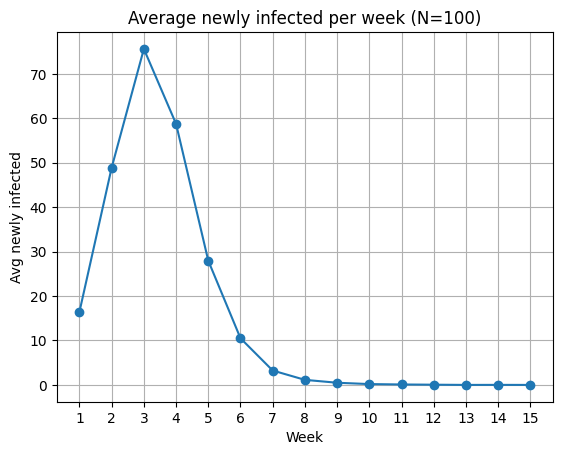

In [ ]:
plot_avg_new_infected([avg_new_inf])

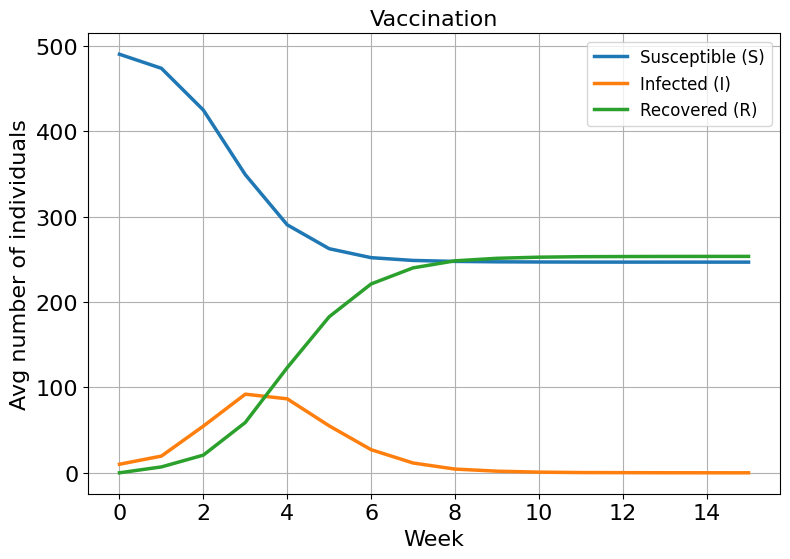

In [ ]:
plot_avg_SIR([(avg_S, avg_I, avg_R, "Vaccination" )])

## Observations:

 It can be observed that vaccination reduces the magnitude of the epidemic and shortens its duration by approximately one week. The peak number of infected individuals is lower in the vaccinated case, and the epidemic ends earlier compared to the scenario without vaccination. By observing the total number of individuals, it is also evident that more than 100 fewer people become infected overall due to preventive vaccination of healthy individuals. This shows that vaccination effectively limits the spread of the disease and reduces the total number of infections.


## **1.5 The H1N1 pandemic in Sweden 2009**

Tasks:
- Simualte pandemics betwwen week 42, 2009 and week 5, 2010
- Fraction of vaccinated people is given for each week
- Population is scaled down by the factor $10^4$, thus $n=934$


The real numbers of infected people per each week are given.
The main task is to perform the gradient based algorithm, to obtain the same numbers for each week with simulation.

### Gradient-based parameter search

We perform a gradient-based search over the parameter space $(k, \beta, \rho)$
to fit the simulated pandemic to real data.

**Initialization**
$$
k_0 = 10,\quad \beta_0 = 0.3,\quad \rho_0 = 0.6,
$$
$$
\Delta k = 1,\quad \Delta \beta = 0.1,\quad \Delta \rho = 0.1.
$$

**Search step**

For
$$
k \in \{k_0-\Delta k, k_0, k_0+\Delta k\},\quad
\beta \in \{\beta_0-\Delta \beta, \beta_0, \beta_0+\Delta \beta\},\quad
\rho \in \{\rho_0-\Delta \rho, \rho_0, \rho_0+\Delta \rho\},
$$

1. Generate a preferential attachment graph with $|V|=934$ and average degree $k$.
2. Simulate the pandemic for 15 weeks (from week 42), repeat $N=10$ times, and compute
   the average weekly infections $I(t)$.
3. Compute
$$
\text{RMSE} =
\sqrt{\frac{1}{15}\sum_{t=1}^{15} \left(I(t)-I_0(t)\right)^2 }.
$$

**Update rule**

Update $(k_0,\beta_0,\rho_0)$ to the parameters minimizing RMSE.
If no improvement is found, reduce the step sizes
$$
\Delta k,\ \Delta \beta,\ \Delta \rho
$$
divide them by $2$, and continue the search.
The algorithm stops when no further improvement is possible (minimum size for parameters reached)
.


In [ ]:
def gradient_parameters_search(type_,
                               k0,
                               beta0,
                               rho0,
                               p0,
                               delta_k,
                               delta_beta,
                               delta_rho,
                               delta_p,
                               vaccination_distribution,
                               init_infected,
                               infected_per_week_gt,
                               n = 934,
                               loss = root_mean_squared_error):

  min_delta_k=1
  min_delta_beta=0.01
  min_delta_rho=0.01

  #Only for small network
  min_delta_p = 0.01

  while True:

    best_combination = [(k0, beta0, rho0, p0), np.inf]

    #Generate parameter spaces
    k_space = np.array([k0-delta_k, k0, k0+delta_k], dtype = int)
    k_space = np.clip(k_space, 1, None)  # no sense to have k = 0

    beta_space = np.array([beta0-delta_beta, beta0, beta0+delta_beta], dtype=np.float64)
    beta_space = np.clip(beta_space, 0.01, 1.0)

    rho_space = np.array([rho0-delta_rho, rho0, rho0+delta_rho], dtype=np.float64)
    rho_space  = np.clip(rho_space,  0.01, 1.0)

    if type_ == "Small Network":
      p_space = np.array([p0-delta_p, p0, p0+delta_p], dtype=np.float64)
      p_space = np.clip(p_space, 0.0, 1.0)
    else:
      p_space = np.array([0], dtype=np.float64)


    #Generate Cartesian product to get all possible combinations
    cartesian_product_iterator = product(k_space, beta_space, rho_space, p_space)
    all_combinations = list(cartesian_product_iterator)

    for (k, beta, rho, p) in all_combinations:

      #Check the model of the random graph
      if type_ == "Preferentiral attachement":
        G = generate_preferential_attachement(n, k)
      elif type_ == "Small Network":
        G = generate_small_world_network(n, k, p)

      avg_new_inf, _, _, _ = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, init_infected)

      #Calculate root mean square error
      RMSE = loss(infected_per_week_gt, avg_new_inf)
      if RMSE < best_combination[1]:
        best_combination[0] = (k, beta, rho, p)
        best_combination[1] = RMSE

    #If the result was the same set of parameters, the algorithm should stop. ---> It is not good practice to compare floats with ==. Chat GPT suggested to use np.isclose method
    if best_combination[0][0] == k0 and np.isclose(best_combination[0][1], beta0) and np.isclose(best_combination[0][2], rho0) and np.isclose(best_combination[0][3], p0):

        #Anyway before break at first, we also try to reduce delta steps, according to the hint given in the task
        delta_k = max(min_delta_k, delta_k // 2)
        delta_beta /= 2
        delta_rho  /= 2

        #This is only important when we work with small network model;
        #In preferential attachement model p_flag is always true to skip that check

        p_flag = True
        if type_ == "Small Network":
          delta_p /= 2

          #In small network model to check if we reached the limit
          p_flag = delta_p < min_delta_p

        # stop if steps are too small
        if delta_k == min_delta_k and delta_beta < min_delta_beta and delta_rho < min_delta_rho and p_flag:
            break

    else:
      k0, beta0, rho0, p0 = best_combination[0][0], best_combination[0][1], best_combination[0][2], best_combination[0][3]

  return best_combination

In [ ]:
vaccination_distribution = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infected_per_week_gt = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_params = gradient_parameters_search(
                           type_="Preferentiral attachement",
                           k0=10,
                           beta0=0.3,
                           rho0=0.6,
                           p0=0,
                           delta_k=1,
                           delta_beta=0.1,
                           delta_rho=0.1,
                           delta_p=0,
                           vaccination_distribution=vaccination_distribution,
                           init_infected=infected_per_week_gt[0], # first elements corresponds to the initial number o infected
                           infected_per_week_gt=np.array(infected_per_week_gt[1:]) #
                           )

### **Running simulation with obtained parameters**

In [ ]:
#Parameters
n = 934
k, beta, rho = best_params[0][0], best_params[0][1], best_params[0][2]
vaccination_distribution = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]

#Execution
G = generate_preferential_attachement(n, k)
avg_new_inf, avg_S, avg_I, avg_R = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, 1)

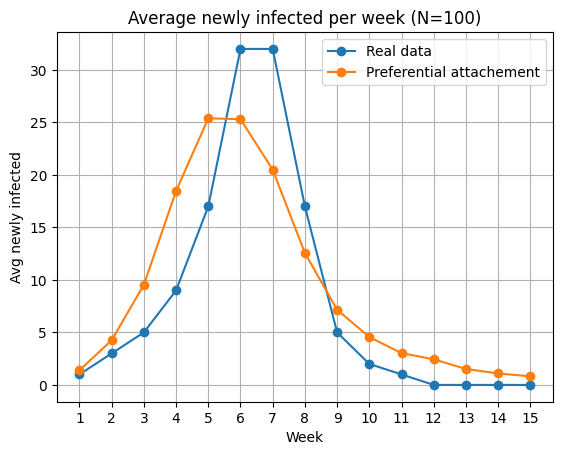

In [ ]:
plot_avg_new_infected([infected_per_week_gt[1:], avg_new_inf], ["Real data", "Preferential attachement"],
)

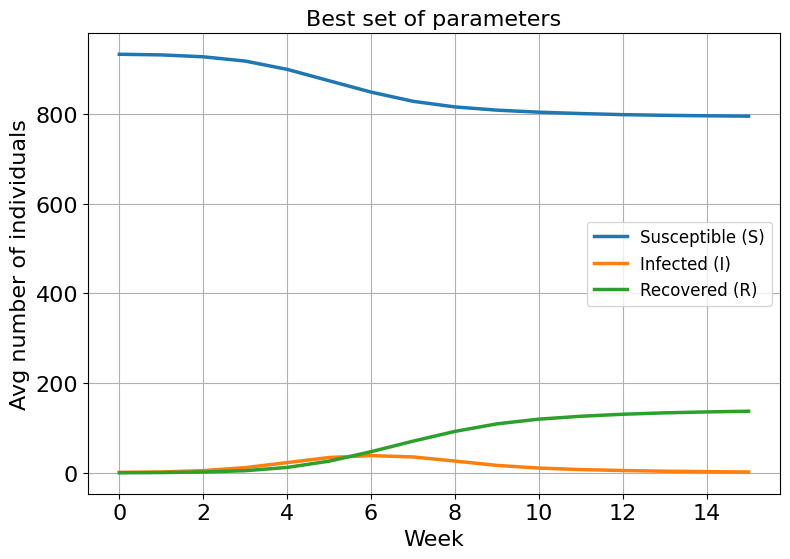

In [ ]:
plot_avg_SIR([(avg_S, avg_I, avg_R, "Best set of parameters")])

In [ ]:
prev_avg_new_inf = avg_new_inf #saving this for plot comparision with next model

### **Observations:**

The smallest RMSE is obtained for this set of parameters:
$$
k = 8; \beta = 0.1875; \rho = 0.625
$$


The model captures the overall epidemic dynamics well, but exhibits a slightly faster initial spread, an earlier and lower peak, and a slower decay compared to real data. Generaly magnitudes are not matched well.

### **1.6 Challenge (Optional) - Small World Network**

This model is motivated by the empirical observation that many real-world networks exhibit a small diameter and high clustering.

The preferential attachment model tends to create a few highly connected hub nodes, which may not be the most intuitive choice for describing the spread of an epidemic. In reality, diseases often propagate through multiple small, highly connected groups, rather than through a small number of dominant hubs. Individuals within these groups interact frequently, while only a limited number of connections link different groups together.

A simple illustrative example is a classroom of students, which represents a small, highly connected group. If one student becomes infected, the disease can spread rapidly within the classroom. These students are also connected to their families, forming additional small groups. Family members, in turn, are often highly connected to their colleagues in the workplace, creating further tightly knit groups. Through these inter-group connections, the disease can propagate across different social contexts and eventually spread throughout the broader population.

In fact, what we did in the problem 1.1, where we have created symmetric k regular graph, represents the basis of small world network model. But now, we add random long connections between nodes.



In [ ]:
def generate_small_world_network(n, k, p_add):

    G = symmetric_k_regular_graph(n, k)
    num_random_edges = int(p_add * n * k / 2)

    nodes = list(G.nodes())
    added = 0
    rng = np.random.default_rng(42)

    while added < num_random_edges:
        u, v = rng.choice(nodes, size=2, replace=False)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            added += 1

    return G

## **Getting best parameters (base algorithm)**

In [ ]:
vaccination_distribution = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infected_per_week_gt = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_params = gradient_parameters_search(
                           type_="Small Network",
                           k0=10,
                           beta0=0.3,
                           rho0=0.6,
                           p0=0.5,
                           delta_k=1,
                           delta_beta=0.1,
                           delta_rho=0.1,
                           delta_p=0.1,
                           vaccination_distribution=vaccination_distribution,
                           init_infected=infected_per_week_gt[0], # first elements corresponds to the initial number o infected
                           infected_per_week_gt=np.array(infected_per_week_gt[1:]) #
                           )

### **Running simulation with obtained parameters**

In [ ]:
#Parameters
n = 934
k, beta, rho, p = best_params[0][0], best_params[0][1], best_params[0][2], best_params[0][3]
vaccination_distribution = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]

#Execution
G = generate_small_world_network(n, k, p)
avg_new_inf, avg_S, avg_I, avg_R = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, infected_per_week_gt[0])

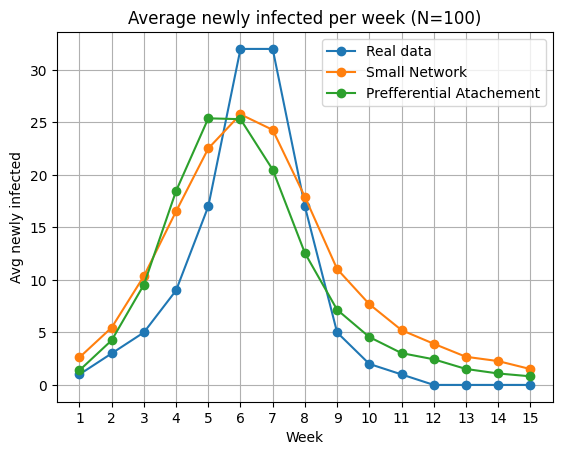

In [ ]:
plot_avg_new_infected([infected_per_week_gt[1:], avg_new_inf, prev_avg_new_inf], ["Real data", "Small Network", "Prefferential Atachement"],
)

### Observations

The proposed network has achieved more or less the same results as preferential attachement model. It is meaningful to observe that both networks overestimate values from the first 5 weeks, and after the peak of pandemic, while in the same time underestimate values for the peak of pandemic. We should somehow signal to the models to reduce some, while in the same time increase other values. So, a possible and ituitive choice that could bring some improvements is modification of the loss function of the initial algorithm. We experiemnt the effect of replacing classic RMSE, with its weighted version.

### **Weighted Root Mean Sqaured Error**

Weighted Root Mean Squared Error (WRMSE) is an error metric that assigns different weights to individual observations, allowing some errors to have a greater impact on the final value. It is defined as:

$$
\mathrm{WRMSE} = \sqrt{\frac{\sum_{i=1}^{n} w_i (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} w_i}}
$$

where $y_i$ represents the true values, $\hat{y}_i$ the predicted values, and $w_i$ the weights that indicate the importance of each observation.


In [ ]:
# Modification of the original alghoritm

def weighted_rmse(y_true, y_pred, eps=1e-8):
    weights = np.array(y_true, dtype=float) + 1.0
    return np.sqrt(
        np.sum(weights * (y_pred - y_true)**2) / np.sum(weights + eps)
    )

In [ ]:
vaccination_distribution = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infected_per_week_gt = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_params_pa = gradient_parameters_search(
                           type_="Preferentiral attachement",
                           k0=10,
                           beta0=0.3,
                           rho0=0.6,
                           p0=0.5,
                           delta_k=1,
                           delta_beta=0.1,
                           delta_rho=0.1,
                           delta_p=0.1,
                           vaccination_distribution=vaccination_distribution,
                           init_infected=infected_per_week_gt[0], # first elements corresponds to the initial number o infected
                           infected_per_week_gt=np.array(infected_per_week_gt[1:]),
                           loss=weighted_rmse #
#
                           )

best_params_sn = gradient_parameters_search(
                           type_="Small Network",
                           k0=10,
                           beta0=0.3,
                           rho0=0.6,
                           p0=0.5,
                           delta_k=1,
                           delta_beta=0.1,
                           delta_rho=0.1,
                           delta_p=0.1,
                           vaccination_distribution=vaccination_distribution,
                           init_infected=infected_per_week_gt[0], # first elements corresponds to the initial number o infected
                           infected_per_week_gt=np.array(infected_per_week_gt[1:]),
                           loss=weighted_rmse #
                           )

In [ ]:
#Parameters
n = 934
k, beta, rho, p = best_params_pa[0][0], best_params_pa[0][1], best_params_pa[0][2], best_params_pa[0][3]

#Execution
G = generate_preferential_attachement(n, k)
avg_new_inf_pa, avg_S_pa, avg_I_pa, avg_R_pa = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, infected_per_week_gt[0])

In [ ]:
#Parameters
n = 934
k, beta, rho, p = best_params_sn[0][0], best_params_sn[0][1], best_params_sn[0][2], best_params_sn[0][3]

#Execution
G = generate_small_world_network(n, k, p)
avg_new_inf_sn, avg_S_sn, avg_I_sn, avg_R_sn = simulate_SIR_dynamic_with_vaccination(G, beta, rho, vaccination_distribution, infected_per_week_gt[0])

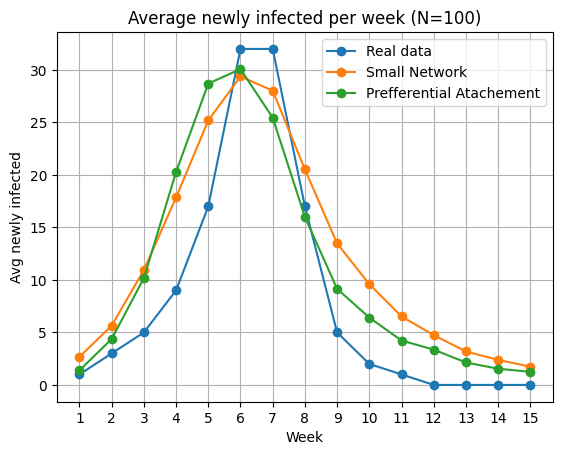

In [ ]:
plot_avg_new_infected([infected_per_week_gt[1:], avg_new_inf_sn, avg_new_inf_pa], ["Real data", "Small Network", "Prefferential Atachement"],
)

### Observations:
Compared to the RMSE-based optimization, the use of WRMSE improves
the agreement with real data primarily in the peak region of the epidemic.
In particular, both the timing and the magnitude of the peak of newly infected
individuals are more accurately captured, while the accuracy in the early growth
phase and the late decay phase remains almost unchanged.

## **2. Network Games and Dynamics**

Consider a game $(V, A, \{u_i\})$ with player set
$$
V = \{1, 2, \dots, n\}
$$
and action set
$$
A = \{-1, +1\}.
$$

Players are divided into two classes:
$$
V_1 = \{1, \dots, n_1\}, \quad
V_2 = \{n_1 + 1, \dots, n\}.
$$

The utility functions are given by
$$
u_i(x_i, x_{-i}) =
\begin{cases}
\displaystyle \frac{1}{2} \sum_{j \neq i} |x_i + x_j|, & \text{if } i \in V_1, \\[10pt]
\displaystyle \frac{1}{2} \sum_{j \neq i} |x_i - x_j|, & \text{if } i \in V_2.
\end{cases}
$$

In other words, players in $V_1$ have the utility function of a
network coordination game, while players in $V_2$ have the utility
function of a network anti-coordination game.
The total number of players is $n=3$, and the interaction structure is given
by a complete undirected graph $G$.

It is important to note that this network game is pairwise separable.
This means that each player engages in a separate two-player game with each
of her neighbors, and the overall utility is obtained by summing the payoffs
from these pairwise interactions.


#### **Define configurations**

In [ ]:
def make_configs(n, n1_list):
    configs = []
    for k in n1_list:
        cfg = {i: (0 if i < k else 1) for i in range(n)} #V1 -> 0, V2 -> 2
        configs.append(cfg)
    return configs

n = 3
n1_list = [3, 2, 1, 0]

configs = make_configs(n, n1_list)

If a node belongs to the group V1, it follows this payoff matrix $\varphi_1$

|   | -1   | +1   |
|---|-----|-----|
| **-1** | 1 | 0 |
| **+1** | 0 | 1 |

This implies that for the nodes in V1, the best choice is to copy the answer of other player. Thus, if all nodes belong to the group V1, we simulate majority game. (a1)

If a node belongs to the group V2, it follows this payoff matrix $\varphi_2$


|   | -1   | +1   |
|---|-----|-----|
| **-0** | 0 | 1 |
| **+1** | 1 | 0 |

This implies that for the nodes in V2, the best choice is to counter the answer of other player. Thus, if all nodes belong to the group V2, we simulate typical minority game.(a4)

The results for these two configurations can be obtained with theoretical arguments. However this is not the case for the (a2), (a3), as they represent mix of majority/minority games.

In the (a2) and (a3), some nodes have the utility function of a majority game,
while others have the utility function of a minority game. In general, determining the existence and structure of Nash equilibria for
this class of heterogeneous network games is a difficult problem.

For this reason, we use the function `is_nash` where we enumerate all possible action profiles and, for each profile, verify whether it satisfies the Nash equilibrium condition by checking if any player can improve their utility through a unilateral deviation. This brute force approach is possible since the size of configuration space is $2^3 = 8$, but for the larger networks is not appropriate.

**- REMARK: For simplicity reasons, the action -1 is encoded with 0 in the following code**

In [ ]:
# available actions
actions = [0,1]  # 0 corresponds to -1
n_actions = len(actions)
phi = np.array([[[1,0],[0,1]], [[0,1], [1, 0]]])

def utility(player, group, x):

    result = 0
    for other_player in G.neighbors(player):
         result += phi[group, x[player], x[other_player]] #x[player] is an action of the player
    return result


def is_nash(x):

  #we send the whole configuration, and check the utility of each player
  for i in range(n):
    #current utility
    current_u = utility(i, G.nodes[i]["group"], x)

    for ac in actions:
      if ac != x[i]:
        x_new = list(x)
        x_new[i] = ac

        new_utility = utility(i, G.nodes[i]["group"], x_new)
        if new_utility > current_u:
          return False

  return True

#### **Plotting results**

In [ ]:
def plot_nash_grid(G, config_idx, config, nash_list, max_cols=2):
    nx.set_node_attributes(G, config, name="group")

    pos = nx.spring_layout(G)

    labels = {i: f"V{G.nodes[i]['group']+1}" for i in G.nodes()}

    k = len(nash_list)

    if k == 0:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        nx.draw(G, pos=pos, ax=ax, with_labels=False)
        nx.draw_networkx_labels(G, pos=pos, labels=labels, ax=ax)
        ax.set_title(f"a{config_idx}: no pure Nash equilibrium")
        ax.axis("off")
        plt.show()
        return

    n_cols = min(max_cols, k)
    n_rows = math.ceil(k / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    axes_list = np.array(axes).ravel()

    for idx, x in enumerate(nash_list):
        ax = axes_list[idx]
        node_colors = [x[i] for i in G.nodes()]

        nx.draw(
            G,
            pos=pos,
            ax=ax,
            with_labels=False,
            node_color=node_colors,
            cmap=plt.cm.bwr,
            vmin=0,
            vmax=1
        )
        nx.draw_networkx_labels(G, pos=pos, labels=labels, ax=ax)

        ax.set_title(f"NE {idx+1}")
        ax.axis("off")

    for ax in axes_list[k:]:
        ax.axis("off")

    legend_elements = [
        Patch(facecolor=plt.cm.bwr(0.0), label="Action -1"),
        Patch(facecolor=plt.cm.bwr(1.0), label="Action 1"),
    ]
    fig.legend(handles=legend_elements, loc="lower center", ncol=2, fontsize=10)

    fig.suptitle(f"Configuration a{config_idx}", fontsize=14)
    plt.tight_layout(rect=[0, 0.1, 1, 0.92])

    plt.savefig(f"nash_equilibria_a{config_idx}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


Nash Equilibrium for a1:[(0, 0, 0), (1, 1, 1)]


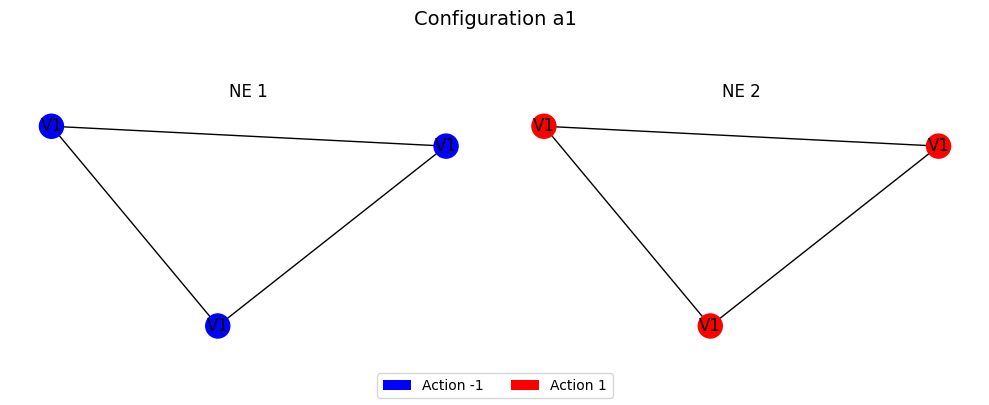

Nash Equilibrium for a2:[(0, 0, 1), (1, 1, 0)]


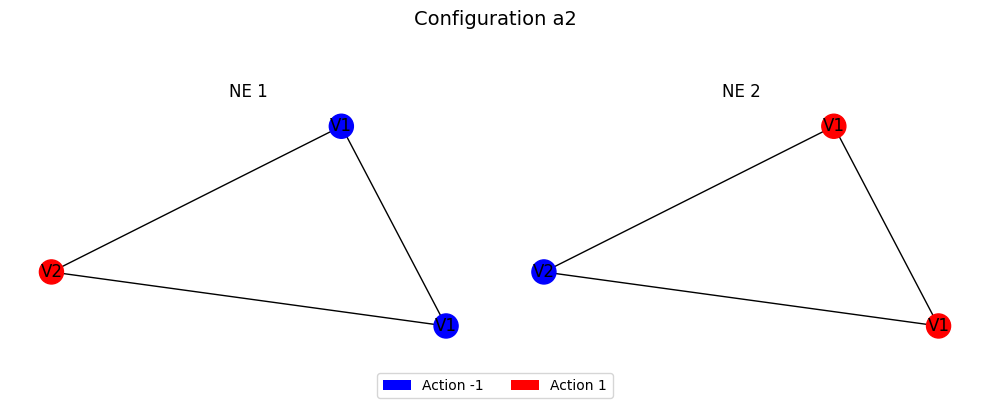

Nash Equilibrium for a3:[(0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 1, 0)]


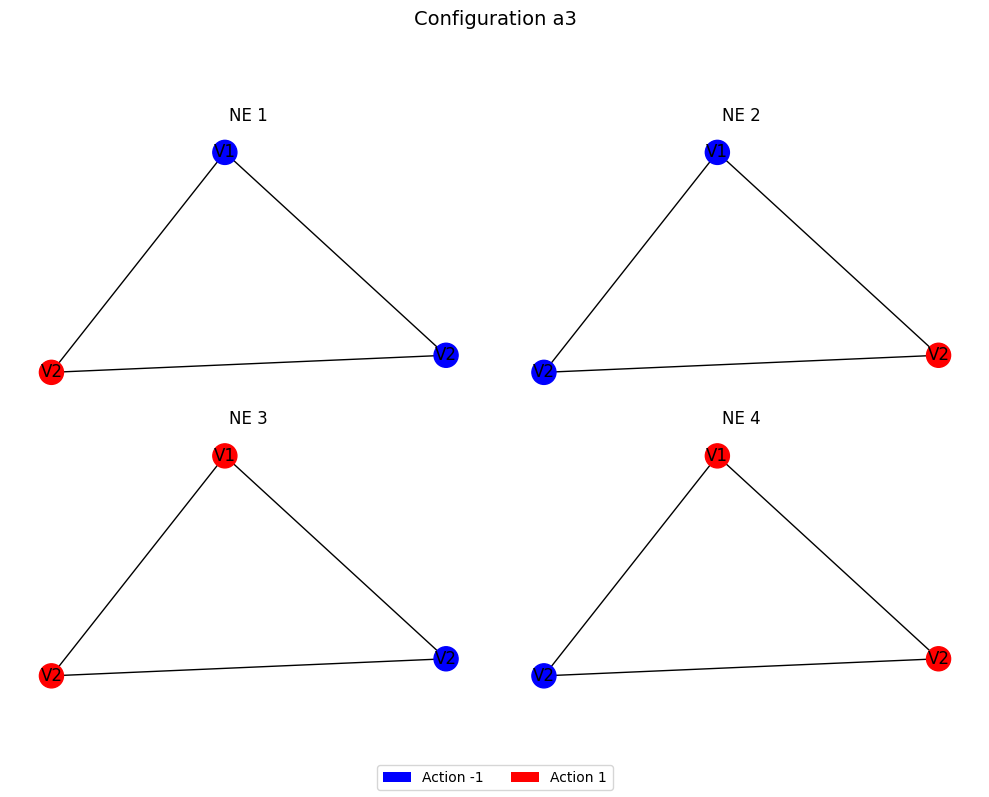

Nash Equilibrium for a4:[(0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)]


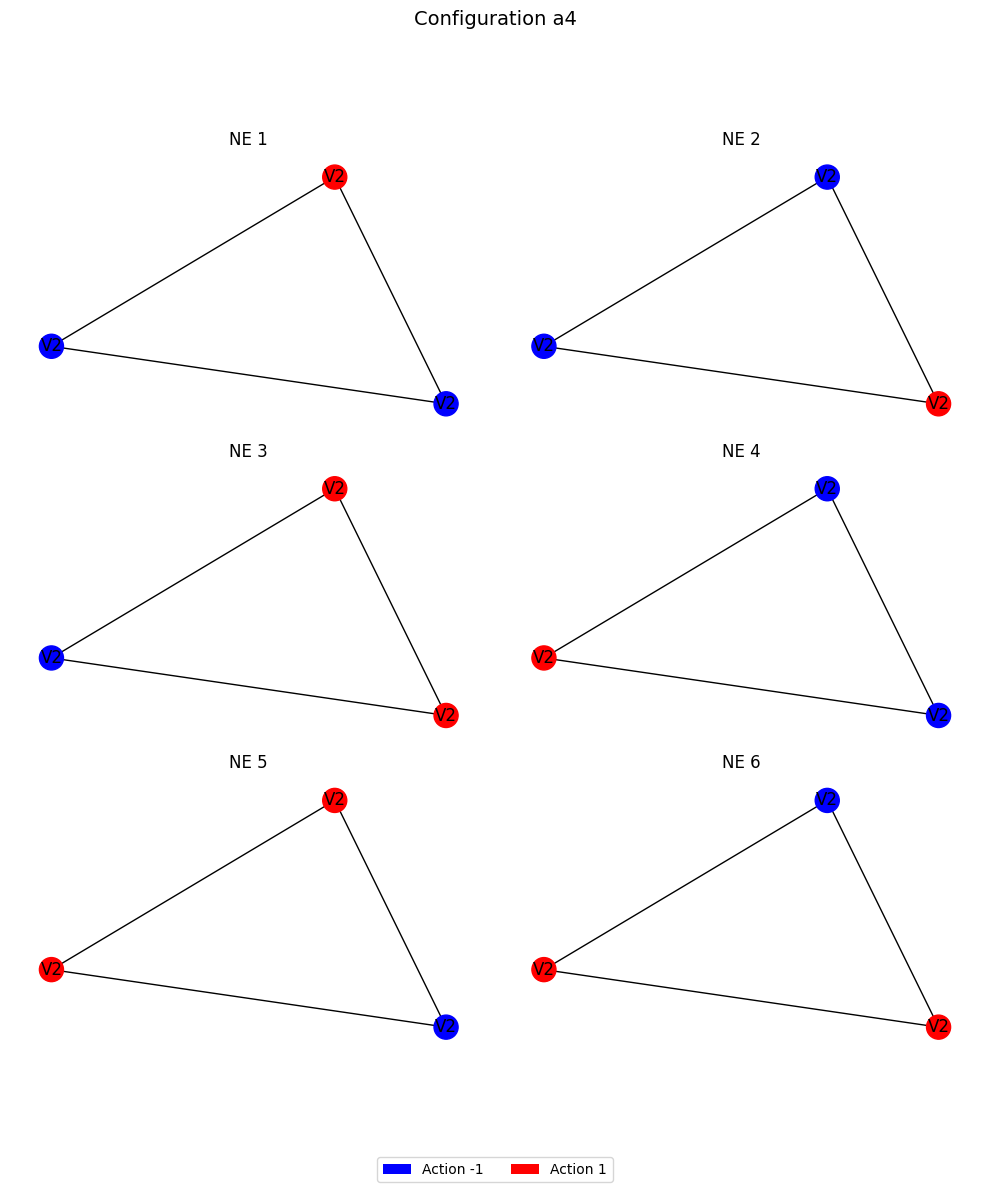

In [ ]:
profiles = list(itertools.product([0,1], repeat=3))

for i, config in enumerate(configs):

  G = nx.complete_graph(n)
  nx.set_node_attributes(G, config, name="group")
  nash_eq = [x for x in profiles if is_nash(x)]
  print(f"Nash Equilibrium for a{i+1}:{nash_eq}")

  plot_nash_grid(G, i+1, config, nash_eq)


### **Observations**

**a1)** The majority game on a complete graph admits two Nash equilibria: all players choosing $-1$, and all players choosing $1$. (Consensus configurations) This is confirmed by the simulations. Both equilibria are strict.

**a2)** In this setting, two players aim to match the actions of other players, while the third player adopts an opposite strategy. The equilibria correspond to configurations in which the two players in group $V_1$ choose the same action, and the player in $V_2$ chooses the opposite action. These are not strict equilibria.

**a3)** In this setting, two players follow an anti-coordination principle, while the third player copies their actions. The equilibria correspond to configurations in which the player in $V_1$ copies the action of one of its neighbors, while the remaining player in $V_2$ chooses the opposite action. All symmetric configurations are equilibria.

**a4)** The minority game on a complete graph with odd number of players admits multiple Nash equilibria. These equilibria can be divided into two classes: one in which $\frac{n-1}{2}$ players choose the first strategy and $\frac{n+1}{2}$ players choose the second strategy, and the symmetric class. Anyway, none of these equilibria is strict, as player always has multiple choices with the same payoff.


### **2.1 Discrete-time asynchronous best response dynamics and noisy best response dynamics in the vanishing noise limit**

The **discrete-time asynchronous best response (BR) dynamics** is a Markov chain $X(t)$ with state space $\mathcal X= \mathcal A^{\mathcal V}$ coinciding with the configuration space of the game. At time instant $t$, when the chain is in $X(t)$, one player $i$ is selected uniformly at random in $\mathcal V$ and changes her action to a best response chosen uniformly at random in the set $B_i(X(t)_{-i})$. In other words, a player changes an action only if it strongly benefits from it or if it does not lose anything by changing the action. This dynamics can get stucked in the equilibriums which are not global maximizers of potential function, if they exist.


The **discrete-time noisy best response (NBR)** dynamics is a Markov chain
$X(t)$ with state space $\mathcal X = \mathcal A^{\mathcal V}$.
At each time instant $t$, one player $i \in \mathcal V$ is selected
uniformly at random and updates her action according to the logit rule
$$
\mathbb P\!\left(X_i(t+1)=a_i \mid X(t)\right)
= \frac{\exp\!\left(\eta\, u_i(a_i, X_{-i}(t))\right)}
{\sum_{a_i' \in \mathcal A_i} \exp\!\left(\eta\, u_i(a_i', X_{-i}(t))\right)},
$$
while the actions of all other players remain unchanged.
The parameter $\eta>0$ represents the inverse noise level.

If the underlying game is a potential game with potential function
$\Phi \colon \mathcal X \to \mathbb R$, the NBR dynamics is irreducible
and admits a unique invariant distribution $\pi$ whose support is the
whole configuration space $\mathcal X$.
Moreover, $\pi$ is given by the Gibbs distribution
$$
\pi_x = \frac{e^{\eta \Phi(x)}}{Z_\eta},
\qquad
Z_\eta = \sum_{y \in \mathcal X} e^{\eta \Phi(y)} .
$$

As $\eta \to \infty$ (vanishing noise limit), the invariant distribution concentrates on the
set of global maximizers of the potential function $\Phi$, whereas for
finite $\eta$ every configuration is visited with positive
probability.



In [ ]:
def best_response_dynamics(n, n_actions, actions, group, noise = False, eta = 10):

  n_config = n_actions**n
  P = sp.sparse.lil_matrix((n_config, n_config))

  n_states = tuple(n_actions for _ in range(n))
  profiles = list(itertools.product(actions, repeat=n))

  for x_id, profile in enumerate(profiles):

      x = np.array(profile)
      for player in range(n):

          utilities = np.zeros(n_actions, dtype=float)
          for a in actions:
              y = x.copy()
              y[player] = a
              utilities[a] = utility(player, group, y)

          prob_choose_player = 1.0 / n

          if noise:
              exp_utilities = np.exp(eta * utilities)
              probs = exp_utilities / np.sum(exp_utilities)
          else:

              max_u = np.max(utilities)
              best_actions = [a for a in actions if utilities[a] == max_u]
              probs = np.zeros(n_actions, dtype=float)
              probs[best_actions] = 1.0 / len(best_actions)


          for a in actions:
              if probs[a] == 0:
                  continue
              y = x.copy()
              y[player] = a
              y_id = np.ravel_multi_index(tuple(y), dims=n_states)
              P[x_id, y_id] += prob_choose_player * probs[a]

  return P.tocsr()

## **b1**) Analysis for n1 = 3 - **Majority game**

### **Best Response Dynamics**

We consider the Majority Game with $n_1=3$ players. The action space is
$$
x \in \{-1,+1\}^3,
$$
and we compute
$$
\lim_{t \to +\infty} \mathbb{P}\big(X(t)=x \mid X(0)=(+1,-1,+1)\big).
$$

The game admits exactly two Nash equilibria,
$$
(+1,+1,+1) \quad \text{and} \quad (-1,-1,-1),
$$
which are consensus configurations. Under Best Response (BR) dynamics, these
states are absorbing.

The BR dynamics induces a non-irreducible Markov chain and therefore does not
admit a unique invariant distribution. As a consequence, the limiting
distribution depends on the initial condition.

Starting from
$$
X(0) = (+1,-1,+1),
$$

From this state, it is possible to reach both consensus equilibria.
In particular, players currently choosing action
+1 may switch to  −1 without decreasing the potential, and vice versa.
 Hence, both absorbing states are reached with
positive probability.

Therefore, there exist $p_+, p_- > 0$ with $p_+ + p_- = 1$ such that
$$
\lim_{t \to +\infty} \mathbb{P}\big(X(t)=x \mid X(0)=(+1,-1,+1)\big)
=
\begin{cases}
p_+, & x=(+1,+1,+1), \\
p_-, & x=(-1,-1,-1), \\
0, & \text{otherwise}.
\end{cases}
$$

All non-consensus configurations are transient states, that is why their probabilities are equal to 0.

To obtain values for $p_+$ and $p_-$, we compute hitting probabilities for reaching these two states. This can be done by performing simulation, or solving linear system by using transition matrix P.


In [ ]:
P_BR = best_response_dynamics(n, 2, actions, 0)

### Plotting tranistion graph

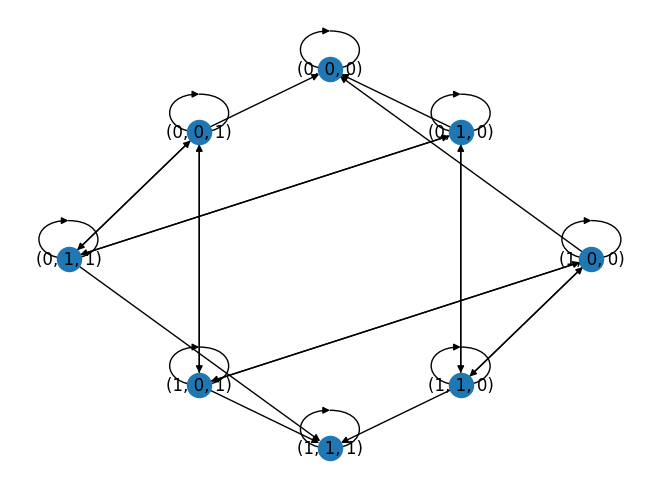

In [ ]:
transition_graph = nx.from_numpy_array(P_BR, create_using=nx.DiGraph)
labels = {i: profiles[i] for i in range(len(profiles))}

sx, sy = 2.0, 2.0
pos = {
    0: (0*sx,  3*sy),   # top
    1: (-1*sx, 2*sy),   # upper-left
    2: ( 1*sx, 2*sy),   # upper-right
    3: (-2*sx, 0*sy),   # left
    4: ( 2*sx, 0*sy),   # right
    5: (-1*sx,-2*sy),   # lower-left
    6: ( 1*sx,-2*sy),   # lower-right
    7: (0*sx, -3*sy),   # bottom
}

nx.draw(
    transition_graph,
    pos=pos,
    labels=labels,
    with_labels=True,
)

plt.show()


#### **Solving linear system**

In [ ]:
def state_id(profile, n_actions=2):
    n = len(profile)
    return np.ravel_multi_index(tuple(profile), dims=(n_actions,) * n)

def hitting_prob(P, x0, abs_plus=(1,1,1), abs_minus=(0,0,0), n_actions=2):

    S = P.shape[0]

    a_plus = state_id(abs_plus, n_actions)
    a_minus = state_id(abs_minus, n_actions)

    absorbing = {a_plus, a_minus}
    transient = [i for i in range(S) if i not in absorbing]
    pos = {s:i for i, s in enumerate(transient)}

    x0_id = state_id(x0, n_actions)

    # handle trivial case
    if x0_id == a_plus:
        return 1.0
    if x0_id == a_minus:
        return 0.0

    # Build Q and b where b = P(T -> a_plus)
    Q = P[transient, :][:, transient].toarray()# transient to transient
    b = P[transient, a_plus].toarray().ravel() #probabilites from transient to absorbing

    # Solve (I - Q) h = b
    A = np.eye(len(transient)) - Q
    h = np.linalg.solve(A, b)

    return float(h[pos[x0_id]])

In [ ]:
p_plus = hitting_prob(P_BR, x0=(1,0,1))
p_minus = 1.0 - p_plus

print("p_plus (1, 1, 1) =", p_plus)
print("p_minus (-1, -1, -1) =", p_minus)

p_plus (1, 1, 1) = 0.6666666666666664
p_minus (-1, -1, -1) = 0.3333333333333336


##### **We can confirm these results by applying Monte Carlo Simulaion**

In [ ]:
def mc_hitting(P, x0, absorbing, trials=10000, max_steps=10000):

    counts = {a: 0 for a in absorbing}

    for _ in range(trials):
        x = x0
        for _ in range(max_steps):
            if x in absorbing:
                break
            probs = P[x].toarray().ravel()
            x = np.random.choice(len(probs), p=probs)
        counts[x] += 1

    return {a: counts[a] / trials for a in absorbing}


In [ ]:
x0 = profiles.index((1,0,1))
absorbing = [profiles.index((0,0,0)), profiles.index((1,1,1))]

probs = mc_hitting(P_BR, x0, absorbing, trials=20000)

print("P(hit (-1,-1,-1)) = ", probs[absorbing[0]])
print("P(hit (1,1,1)) =", probs[absorbing[1]])


P(hit (0,0,0)) =  0.32985
P(hit (1,1,1)) = 0.67015


### **Noisy Best Response in the vanishing noise limit**

In the case of NBR, transition graph represent hypercube graph in which transition between each state is possible. As mentoined before this setting produces irreducuble Markov chain, which accepts unique invariant distribution no matter of initial conditions. It can be done either by applying upper equation, or computing left eigenvector that corrseponds to eigenvalue 1.

Potential function for majority game is simply computed by counting the number of the same actions within configuration.


<!-- For beta -> inf, it reduces to the BR. -->

In [ ]:
def get_potential_value_majority(x):
    n = len(x)
    Phi = 0
    for i in range(n):
        for j in range(i+1, n):
            if x[i] == x[j]:
                Phi += 1
    return Phi

def get_potential_value_minority(x):
    n = len(x)
    Phi = 0
    for i in range(n):
        for j in range(i+1, n):
            if x[i] != x[j]:
                Phi += 1
    return Phi

def gibbs_distribution(profiles, potential, eta):

    Phi_vals = np.array([potential(np.array(x)) for x in profiles])
    weights = np.exp(eta * Phi_vals)
    Z = np.sum(weights)
    pi = weights / Z
    return pi

In [ ]:
def simulate_chain(P, x0, T=200000):

    n_states = P.shape[0]

    x = x0
    counts = np.zeros(n_states, dtype=float)

    for t in range(T):
        probs = P[x]
        x = np.random.choice(n_states, p=probs)
        counts[x] += 1

    return counts / counts.sum()


In [ ]:
eta = 5.0
pi = gibbs_distribution(profiles, get_potential_value_majority, eta)
print(f"Unique Invariant distribution pi={pi}")

Unique Invariant distribution pi=[4.99931909e-01 2.26968736e-05 2.26968736e-05 2.26968736e-05
 2.26968736e-05 2.26968736e-05 2.26968736e-05 4.99931909e-01]


##### We can further confirm this by computing left eigenvector that corresponds to eigenvalue 1 of transition probability matrix obtained from nosy dynamics.

In [ ]:
P_NBR = best_response_dynamics(n, 2, actions, 0, True, 10)
values,vectors = np.linalg.eig(P_NBR.toarray().T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
print("pi=", pi)

pi= [5.00000087e-01 1.03057715e-09 1.03057711e-09 1.03057678e-09
 1.03057717e-09 1.03057686e-09 1.03057690e-09 4.99999907e-01]


### Simulation for $η = 5$
In the previous case, we examined the vanishing-noise limit with $\eta = 10$.
However, since these values theoretically yield the same invariant distribution,
we perform empirical simulations for a smaller value of $\eta$. In this way, we
reduce the computational time required for the simulation. Indeed, transitions
away from the global maximizers of the potential function are very rare for large $\eta$, and therefore extremely long simulation runs would be needed to observe such transitions.


In [ ]:
P_NBR = best_response_dynamics(n, 2, actions, 0, True, 5)
pi_emp = simulate_chain(P_NBR.toarray(), x0=state_id((1,0,1), 2), T=7000000)
pi_emp

array([6.49945429e-01, 2.44285714e-05, 2.31428571e-05, 2.17142857e-05,
       1.85714286e-05, 1.44285714e-05, 1.42857143e-05, 3.49938000e-01])

### Observations

The results obtained for Noisy Best Response (NBR) in the vanishing-noise limit differ
from those obtained under Best Response (BR) dynamics. Technically, for most of the
time, NBR behaves similarly to BR. However, when observed over large time horizons,
the process spends asymptotically a fraction $1/2$ of the time in the configuration
with all $+1$ and a fraction $1/2$ of the time in the configuration with all $-1$,
independently of the initial condition.

Although NBR leaves the set of global maxima with very small probability, once such a
transition occurs, the process typically remains for a long time in the next visited
state before another rare transition happens. Importantly, in the long run, the
behavior of NBR is independent of the initial condition, which is not the case for
BR dynamics, where the limiting outcome depends on the initial state.


## **b2**) Analysis for n1 = 0 (Minority game)

In the Minority Game ($n_1=0$), Nash equilibria exist but none of them are
strict. In every equilibrium configuration there are players who are
indifferent between their actions. Consequently, under best response
dynamics, transitions between equilibrium configurations are always
possible.

Therefore, all the equilbria represent an aperiodic connected component (sink component).

Although the Markov chain induced by the best response dynamics is not irreducible, the presence of a single closed aperiodic communicating class implies the existence of a unique stationary distribution supported on that class, while all other states are transient ((1,1,1), (-1,-1,-1)).

$$
\pi(i) =
\begin{cases}
\pi_C(i), & i \in C, \\
0,        & i \notin C.
\end{cases}
$$




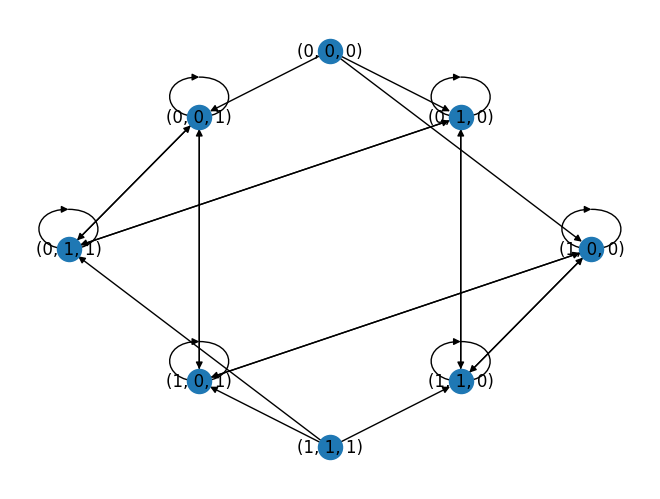

In [ ]:
P_BR = best_response_dynamics(n, 2, actions, 1)
transition_graph = nx.from_numpy_array(P_BR, create_using=nx.DiGraph)
labels = {i: profiles[i] for i in range(len(profiles))}

sx, sy = 2.0, 2.0
pos = {
    0: (0*sx,  3*sy),   # top
    1: (-1*sx, 2*sy),   # upper-left
    2: ( 1*sx, 2*sy),   # upper-right
    3: (-2*sx, 0*sy),   # left
    4: ( 2*sx, 0*sy),   # right
    5: (-1*sx,-2*sy),   # lower-left
    6: ( 1*sx,-2*sy),   # lower-right
    7: (0*sx, -3*sy),   # bottom
}

nx.draw(
    transition_graph,
    pos=pos,
    labels=labels,
    with_labels=True,
)

plt.show()

### Condensation graph

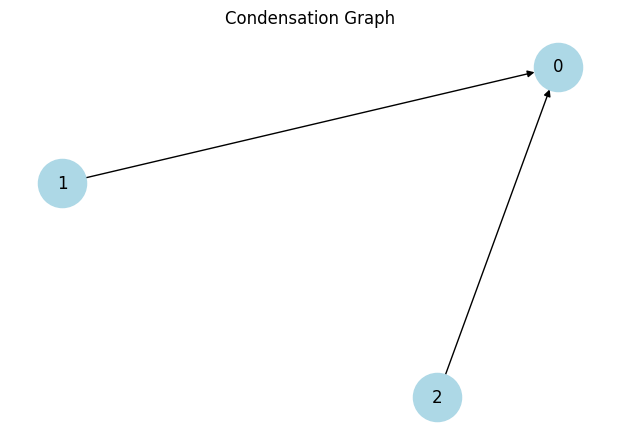

In [ ]:
P = P_BR.toarray()   # ili već dense matrica

H = nx.from_numpy_array(P, create_using=nx.DiGraph)
C = nx.condensation(H)

plt.figure(figsize=(6, 4))

pos = nx.spring_layout(C, seed=1)  # layout for readability

nx.draw(
    C,
    pos,
    with_labels=True,
    node_size=1200,
    node_color="lightblue",
    edge_color="black",
    font_size=12,
    arrows=True
)

plt.title("Condensation Graph")
plt.show()

In [ ]:
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
print("pi=", pi)

pi= [0.         0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.        ]


#### We can confirm these results by applying random walk on the graph, from particulalry given state (1,-1,1)


In [ ]:
pi_emp = simulate_chain(P, x0=state_id((1,0,1), 2), T=200000)
pi_emp

array([0.      , 0.17024 , 0.163435, 0.163855, 0.168445, 0.169595,
       0.16443 , 0.      ])

### **Noisy Best Response in the vanishing noise limit**

In [ ]:
P_NBR = best_response_dynamics(n, 2, actions, 1, True)

In [ ]:
eta = 10
pi = gibbs_distribution(profiles, get_potential_value_minority, eta)
print(f"Unique Invariant distribution pi={pi}")

Unique Invariant distribution pi=[3.43525604e-10 1.66666667e-01 1.66666667e-01 1.66666667e-01
 1.66666667e-01 1.66666667e-01 1.66666667e-01 3.43525604e-10]


### **Simulation**

In [ ]:
pi_emp = simulate_chain(P_NBR.toarray(), x0=state_id((1,0,1), 2), T=200000)
pi_emp

array([0.      , 0.165835, 0.16517 , 0.16632 , 0.165845, 0.16572 ,
       0.17111 , 0.      ])

### **Observations**
In this case, we obtaine the identical stationary distribution for both dynamics